**TIØ4317 Empirical Project Report**<br>
*Magnus Rabben Bautz-Holter*<br>
*Student number: 564346*

**Table of Contents**<br>
0. Necessary python imports<br>
1. Problem statement<br>
2. Data<br>
3. Empirical analysis<br>
4. Conclusion<br>
5. Feedback from peer review<br>
6. Use of LLMs<br>
7. References

**0. Necessary python imports**

In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Too many 'soon deprecated' warning, get rid of them
import warnings
warnings.filterwarnings('ignore')

**1. Problem statement**

Can stock market returns, as measured by the S&P 500 index, be explained using time series data on nonfarm payrolls and the federal funds rate?

This report investigates whether expectations to macroeconomic variables such as employment growth and interest rates can serve as explaining variables of market behavior. Interest rates and employment are two leading macroeconomic variables, as employment is a strong indicator of the current state of the economy and the federal funds interest rate is a tool for adjusting future activity.

Since direct data on market expectations (e.g., futures-implied rate expectations or labor forecasts) is difficult to obtain and quantify, the analysis uses the actual month-over-month changes in nonfarm payrolls and the federal funds rate as proxies for market expectations. This approximation can be justified by the relatively short forecast horizon and the tendency of market expectations to be fairly precise with near-term outcomes.

This problem delves into the world of statistical models for time series explanation and forecasting and aims to make use of several key concepts from the curriculum in TIØ4317.


**2. Data**

This empirical analysis utilises three datasets:
* S&P 500 index (SP500) - daily, indexed data
* US Federal Funds rate (FEDFUNDS) - monthly, percentage data
* US nonfarm payrolls (PAYEMS) - monthly, absolute data

All datasets are retrieved from the US Federal Reserve Economic Data (FRED) provided by the Federal Reserve Bank of St. Louis

In the following section, the raw datasets will be presented graphically. They will then be transformed through log returns, differencing, and frequency alignment, to ensure stationarity and compatibility for time series modeling. The final processed series will be used in the empirical analysis that follows.

*2.1 SP500 data*

In [2]:
sp500 = pd.read_csv('SP500.csv', sep=',')
sp500['observation_date'] = pd.to_datetime(sp500['observation_date'])
sp500.set_index('observation_date', inplace=True)


In [3]:
# Preview of data
sp500.head(10)

,SP500
observation_date,
2015-04-13,2092.43
2015-04-14,2095.84
2015-04-15,2106.63
2015-04-16,2104.99
2015-04-17,2081.18
2015-04-20,2100.40
2015-04-21,2097.29
2015-04-22,2107.96
2015-04-23,2112.93


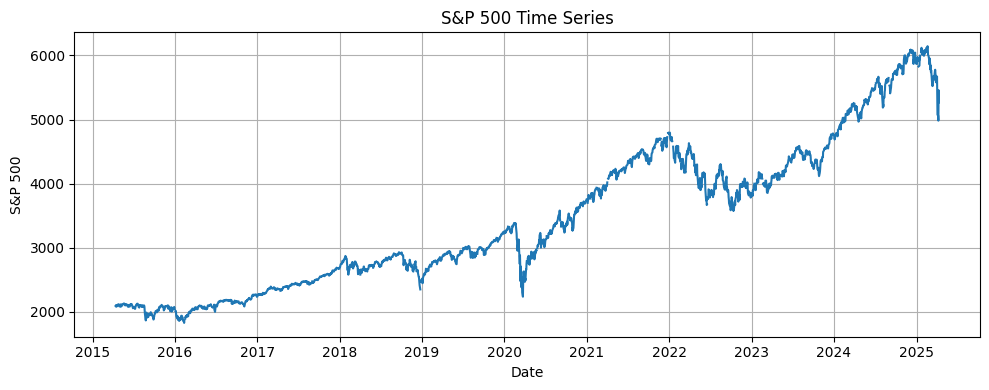

In [4]:
# Plot of S&P 500 time series
plt.figure(figsize=(10, 4))
plt.plot(sp500.index, sp500['SP500'])
plt.title('S&P 500 Time Series')
plt.xlabel('Date')
plt.ylabel('S&P 500')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.2 FEDFUNDS data*

In [5]:
fedfunds = pd.read_csv('FEDFUNDS.csv', sep=',')
fedfunds['observation_date'] = pd.to_datetime(fedfunds['observation_date'])
fedfunds.set_index('observation_date', inplace=True)

In [6]:
# Preview of data
fedfunds.head(10)

,FEDFUNDS
observation_date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
1954-12-01,1.28
1955-01-01,1.39
1955-02-01,1.29
1955-03-01,1.35


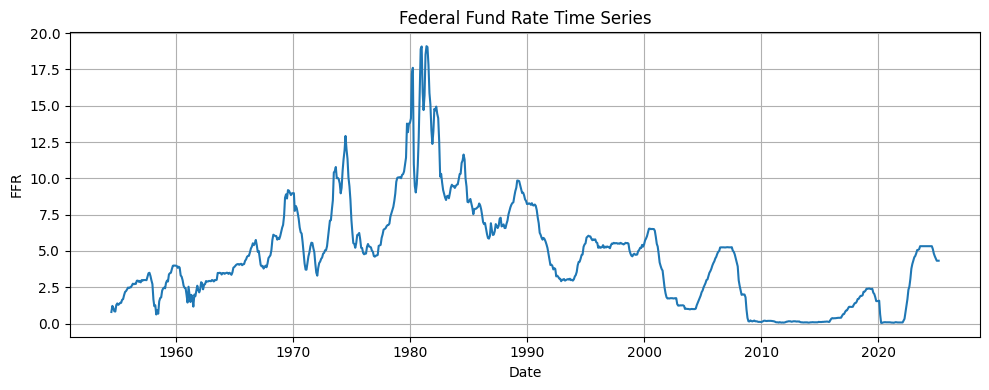

In [7]:
# Plot of Federal Funds Rate time series
plt.figure(figsize=(10, 4))
plt.plot(fedfunds.index, fedfunds['FEDFUNDS'])
plt.title('Federal Fund Rate Time Series')
plt.xlabel('Date')
plt.ylabel('FFR')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.3 PAYEMS data*

In [8]:
payems = pd.read_csv('PAYEMS.csv', sep=',')
payems['observation_date'] = pd.to_datetime(payems['observation_date'])
payems.set_index('observation_date', inplace=True)

In [9]:
# Preview of data
payems.head(10)

,PAYEMS
observation_date,
1939-01-01,29923
1939-02-01,30100
1939-03-01,30280
1939-04-01,30094
1939-05-01,30299
1939-06-01,30502
1939-07-01,30419
1939-08-01,30663
1939-09-01,31031


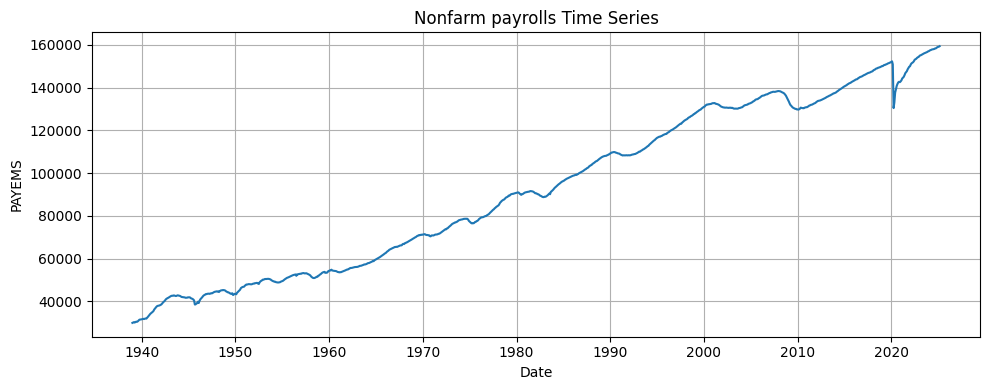

In [10]:
# Plot of Nonfarm payrolls time series
plt.figure(figsize=(10, 4))
plt.plot(payems.index, payems['PAYEMS'])
plt.title('Nonfarm payrolls Time Series')
plt.xlabel('Date')
plt.ylabel('PAYEMS')
plt.grid(True)
plt.tight_layout()
plt.show()

*2.4 Data cleaning and sampling frequency*

First, we want to ensure that all datasets span over the same time period, that being the period from May 2015 to March 2025

In [11]:
# Collect first and last timestamps from each dataset
first_record = max(dataset.index.min() for dataset in [sp500, fedfunds, payems])
last_record = min(dataset.index.max() for dataset in [sp500, fedfunds, payems])

print("Common start date:", first_record)
print("Common end date:", last_record)

# Slice all datasets to the common date range
sp500 = sp500.loc[first_record:last_record + pd.Timedelta(days=2)] # Due to trading days
fedfunds = fedfunds.loc[first_record:last_record]
payems = payems.loc[first_record:last_record]

print("SP500 size: ", sp500.size)
print("FEDFUNDS size: ", fedfunds.size)
print("PAYEMS size: ", payems.size)

Common start date: 2015-04-13 00:00:00
Common end date: 2025-03-01 00:00:00
SP500 size:  2581
FEDFUNDS size:  119
PAYEMS size:  119


Although all datasets now cover the same time period, the SP500 dataset has a daily frequency, while FEDFUNDS and PAYEMS are observed monthly. To ensure consistency, the SP500 data is downsampled to a monthly frequency.

An alternative approach would be to upsample the macroeconomic series to a daily frequency, which could theoretically allow for capturing short-term market reactions and better reflect the high-frequency nature of financial markets. However, this method introduces artificial stability in the macro data, as the same value would be repeated across days without incorporating new information. Therefore, downsampling the SP500 offers a more statistically robust and interpretable framework, while still capturing the market’s reaction to monthly macroeconomic changes.

In [12]:
# Resample SP500 to the first of each month
sp500 = sp500.resample('M').first()

# Re-index all datasets such that information about the date is lost 
# and only information about year and month is retained
sp500.index = sp500.index.to_period('M').to_timestamp()
fedfunds.index = fedfunds.index.to_period('M').to_timestamp()
payems.index = payems.index.to_period('M').to_timestamp()

The nature of the raw data is unfit for statistical modelling as it does not uphold significant assumptions of the ARIMA and GARCH models. Notably, stationarity and homoscedasticity are violated. To capture meaningful cause-and-effect relationships, the data must be appropriately transformed.

*SP500*:<br>
The S&P 500 index is inherently non-stationary, due to long-term economic growth and inflation. To address this, the data is transformed into log-returns, which helps to (1) stabilize the mean and variance over time, thereby achieving stationarity, and (2) approximate a more normally distributed series — a desirable property for modeling returns and volatility.

*PAYEMS*:<br>
Like the SP500, the PAYEMS (nonfarm payrolls) series reflects underlying economic and demographic growth, making it non-stationary in levels. Applying a log-difference transformation (i.e., log-returns) to this series ensures stationarity and provides a more interpretable measure of monthly employment growth.

*FEDFUNDS*:<br>
The Federal Funds Rate is expressed in percentage terms and may appear stationary in levels. However, since this analysis focuses on the market's response to interest rate changes (i.e., monetary policy shocks), the first difference of the FEDFUNDS series is used. This better captures the dynamics between policy shifts and stock market reactions.

In [13]:
# Transform SP500 data by applying log returns instead of absolute level
sp500: pd.Series = np.log(sp500).diff().dropna()

# Remove the first month of returns (April), as it is unique for the SP500
# and missing in the two other datasets
sp500 = sp500.iloc[1:]

# Log returns for payems instead of absolute level
payems: pd.Series = np.log(payems).diff().dropna()

# First difference of fed funds to capture shocks
fedfunds: pd.Series = fedfunds.diff().dropna().squeeze()

In [14]:
# Verify that all datasets are of the same size
print("SP500 size: ", sp500.size)
print("FEDFUNDS size: ", fedfunds.size)
print("PAYEMS size: ", payems.size)

SP500 size:  118
FEDFUNDS size:  118
PAYEMS size:  118


*2.5 Plots of all dataset post transformation*

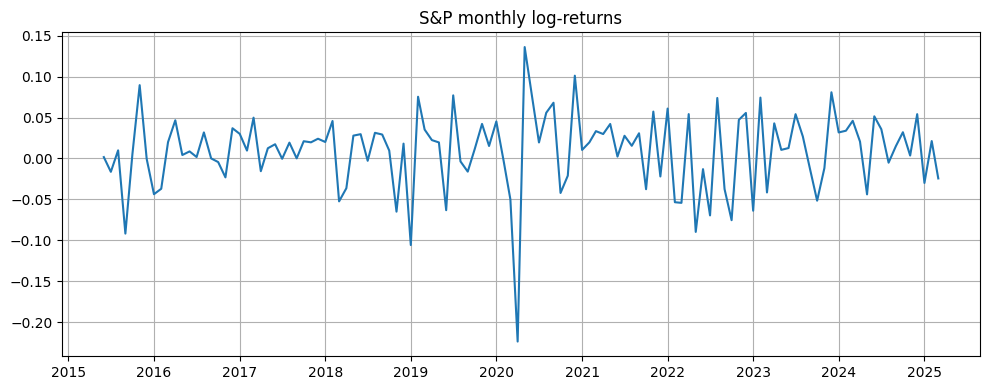

In [15]:
# SP500 post transformation
plt.figure(figsize=(10, 4))
plt.plot(sp500.index, sp500)
plt.title("S&P monthly log-returns")
plt.grid(True)
plt.tight_layout()
plt.show()

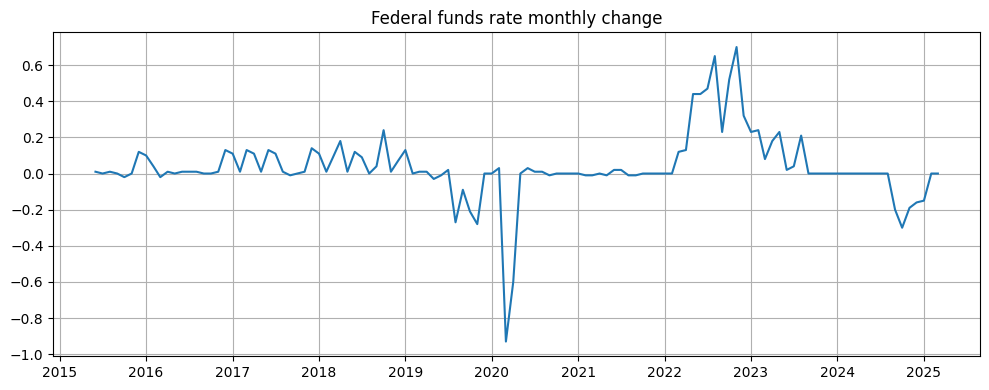

In [16]:
# FEDFUNDS post transformation
plt.figure(figsize=(10, 4))
plt.plot(fedfunds.index, fedfunds)
plt.title("Federal funds rate monthly change")
plt.grid(True)
plt.tight_layout()
plt.show()

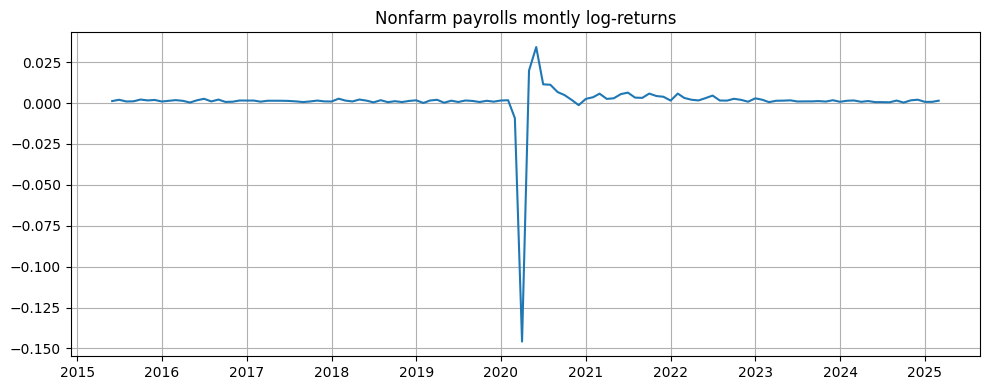

In [17]:
# PAYEMS post transformation
plt.figure(figsize=(10, 4))
plt.plot(payems.index, payems)
plt.title("Nonfarm payrolls montly log-returns")
plt.grid(True)
plt.tight_layout()
plt.show()

**3. Empirical analysis**

For the empirical analysis, I aim to investigate whether changes in nonfarm payrolls (PAYEMS) and the federal funds rate (FEDFUNDS) influence monthly returns of the S&P 500 index.

To model this relationship, I employ an Autoregressive Integrated Moving Average with Exogenous Variables (ARIMAX) framework. The ARIMAX model is well-suited for this analysis because it allows me to:

1. Capture autocorrelation patterns in the S&P 500 returns over time (via AR and MA terms),

2. Account for potential residual non-stationarity (after log-transformation) through differencing, and

3. Explicitly test the influence of external macroeconomic factors, such as PAYEMS and FEDFUNDS, by incorporating them as exogenous regressors.

This structure enables me to assess not only the time series dynamics inherent in stock market returns but also how they respond to changes in key macroeconomic indicators. Moreover, by using month-over-month changes in PAYEMS and FEDFUNDS as proxies for market expectations, I aim to isolate their impact on financial markets during the same period.

To dig deeper into this analysis, I also estimate a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. Financial return series like the S&P 500 are known to exhibit volatility clustering and time-varying risk, characteristics that violate the assumption of constant variance in classical time series models. The GARCH model addresses this by modeling the conditional variance of returns, allowing me to evaluate how macroeconomic variables influence monthly market volatility. 

*3.1 ARIMAX model*

The ARIMAX model extends the classical ARMA model (Box & Jenkins, 1970) by incorporating exogoneous variables as well as differencing. First, the ARMA(p, q) model can be expressed as:

$\phi(L)y_t=\mu+\theta(L)u_t$

where:<br>
$\phi(L)=1-\phi_1(L^1)-...-\phi_p(L^p)$<br>
are the AR terms, such that $L^i$ is equivalent to $y_(t-i)$

$\theta(L)=1+\theta_1(L^1)+...+\theta_q(L^q)$<br>
are the MA terms, such that $L^i$ is equivalent to $y_(t-i)$

$\mu$ is the drift of the model

$u_t ~ N(0, \sigma^2)$<br>
is a white noise term, normally distributed with a mean of 0 and variance $\sigma^2$

The ARIMAX(p, d, q) builds on the ARMA by adding:

$\phi(L)(1-L)^d*y_t=\mu+\theta(L)u_t+\beta*X_t$

where:<br>
$d$ is the degree of differencing required to achieve stationarity

$X_t$ are the exogenous variables, with the corresponding coefficients $\beta$

Explaining the model components one by one: 

1. Autoregressive (AR) part ($\phi(L)y_t$):<br>
Captures the relationship between the current value and its previous lags. Useful for modeling momentum or memory in the data.

2. Differencing (I) part ($(1-L)^d$):<br>
Removes non-stationarity in the series by computing changes (first differences, second differences, etc.).

3. Moving Average (MA) part ($\theta(L)u_t$):<br>
Captures the influence of past forecast errors (shocks) on the current value.

4. Exogenous variables (X) part ($\beta*X_t$):<br>
These are external predictors not generated by the endogenous process. In ARIMAX, this term allows for testing the direct effect of outside influences (e.g., macroeconomic variables) on the target variable.

First, we build a first-pass ARIMAX model:

In [18]:
# Concatenate exogenous data
exog = pd.concat([payems, fedfunds], axis=1)
exog.columns = ["PAYEMS", "FEDFUNDS"]

# Create the model
model = SARIMAX(endog=sp500, exog=exog, order=(1, 1, 1))

# Fit
results = model.fit()

# Print results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                  118
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 207.059
Date:                Fri, 02 May 2025   AIC                           -404.118
Time:                        10:36:37   BIC                           -390.307
Sample:                    06-01-2015   HQIC                          -398.511
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PAYEMS         1.7939      0.939      1.911      0.056      -0.046       3.634
FEDFUNDS      -0.0276      0.016     -1.719      0.086      -0.059       0.004
ar.L1         -0.2184      0.092     -2.383      0.0

The PAYEMS variable has a positive coefficient (1.79) and is marginally statistically significant (p = 0.056), suggesting that increases in nonfarm employment all else alike is associated with higher stock returns.

The FEDFUNDS coefficient is negative (-0.028), aligning with expectations that rate hikes all else alike is associated with lower equity returns, but the result is not statistically significant (p = 0.086) at conventional levels (p = 0.05).

The AR(1) term is significant (p = 0.017), indicating the presence of momentum or temporal autocorrelation in returns.

The MA(1) (p = 0.0803) and residual variance (p = 0.0804) terms are not significant, suggesting limited contribution of past shocks beyond the AR term.

Model diagnostics (e.g., Ljung-Box p = 0.55, Jarque-Bera p = 0.25) indicate no significant autocorrelation or deviation from normality in residuals, supporting the goodness of the model fit.

Then we build on the model to find the best p, d and q parameters according to the AIC and BIC information criterion:

In [19]:
aic_scores = dict()
bic_scores = dict()
models = dict()

# Fit the model on 9 different combinations of orders
for p in range(3):
    for d in range(3):
        for q in range(3):
            model = SARIMAX(endog=sp500, exog=exog, order=(p, d, q))

            results = model.fit()

            aic_scores[f'({p}, {d}, {q})'] = results.aic
            bic_scores[f'({p}, {d}, {q})'] = results.bic
            models[f'({p}, {d}, {q})'] = results

# Find the best (lowest) AIC and BIC orders
best_aic_order = min(aic_scores, key=aic_scores.get)
best_bic_order = min(bic_scores, key=bic_scores.get)

print(f'Best AIC order: {best_aic_order} with AIC = {aic_scores[best_aic_order]:.2f}')
print(f'Best BIC order: {best_bic_order} with BIC = {bic_scores[best_bic_order]:.2f}')

Best AIC order: (2, 0, 2) with AIC = -414.04
Best BIC order: (0, 0, 0) with BIC = -399.81


Model selection results indicate that the ARIMAX(2, 0, 2) specification — including two autoregressive (AR) terms and two moving average (MA) terms with no differencing — is preferred according to the Akaike Information Criterion (AIC). In contrast, the Bayesian Information Criterion (BIC) favors a ARIMAX(0, 0, 0) model that excludes all AR, MA, and differencing components.

The AIC is given by:<br>
$
\mathrm{AIC} = \ln(\hat{\sigma}^2) + \frac{2k}{T}
$
<br> Where $\ln(\hat{\sigma}^2)$ is the sample variance, $k$ is the sum of the AR and MA terms plus 1 and $T$ is the sample size.<br>
In general, AIC penalizes complexity of the model somewhat, but not as hard as BIC. As such, the more complex model was deemed better by AIC.

The BIC is given by:<br>
$
\mathrm{BIC} = \ln(\hat{\sigma}^2) + \frac{k}{T}*\ln(T)
$
<br> Where $\ln(\hat{\sigma}^2)$ is the sample variance, $k$ is the sum of the AR and MA terms plus 1 and $T$ is the sample size.<br>
BIC penalizes complexity more heavily than AIC, and as such the improved fit of the extra AR and MA terms did not justify the increased complexity under the BIC.<br><br>

Given the objective of improving predictive accuracy, this analysis proceeds with the ARIMAX(2, 0, 2) model as recommended by the AIC.

*3.2 ARIMAX(2, 0, 2) model*

In [20]:
# Create the model
improved_model = SARIMAX(endog=sp500, exog=exog, order=(2, 0, 2))

# Fit
results = improved_model.fit()

# Print results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  SP500   No. Observations:                  118
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 214.022
Date:                Fri, 02 May 2025   AIC                           -414.044
Time:                        10:36:47   BIC                           -394.649
Sample:                    06-01-2015   HQIC                          -406.169
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PAYEMS         1.6507      0.381      4.336      0.000       0.905       2.397
FEDFUNDS      -0.0186      0.019     -0.974      0.330      -0.056       0.019
ar.L1          1.2773      0.215      5.954      0.0

The ARIMAX(2, 0, 2) model reveals that nonfarm payroll growth (PAYEMS) has a positive and statistically significant (p < 0.01) effect on S&P 500 returns, with a 1% increase in PAYEMS associated with a 1.65% rise in returns. In contrast, the federal funds rate (FEDFUNDS) displays a negative but statistically insignificant relationship with returns (p = 0.33). The autoregressive and moving average components are significant, capturing short-term momentum and shock persistence in the returns. Diagnostic tests such as Jarque-Bera (p = 0.12) and Ljung-Box (p = 0.91) confirm that the model residuals are free from autocorrelation and approximately normally distributed, though evidence of heteroskedasticity (p = 0.02) suggests that modeling time-varying volatility such as through a GARCH model may further improve the analysis.

*3.3 GARCH model*

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is a framework for modeling and forecasting time-varying volatility in financial time series. Introduced by Bollerslev (1986) as an extension of Engle’s (1982) ARCH model, GARCH is specifically designed to capture volatility clustering — the empirical observation that large changes in asset returns tend to be followed by further large changes (of either sign), while small changes tend to be followed by small ones.

A GARCH(1, 1) model for estimating the return at time t, $y_t$ is given by:

$y_t=\mu+\epsilon_t$

where

$\epsilon_t=\sqrt{\sigma^2_t}*z_t$<br>
$\sigma^2_t=\omega+\alpha*\epsilon^2_(t-1)+\beta*\sigma^2_(t-1)$

where:

$\mu$<br>
is the drift of the process

$z_t~D(0, 1)$<br>
is a white noise term distributed with a mean of 0 and a variance of 1

$\sigma^2_t$<br>
is the variance of the time series at time $t$

$\omega$<br>
is the base volatility

$\alpha$<br>
is the impact of previous shocks

$\beta$<br>
is the impact of previous volatility (persistence)

Each component of the variance equation explained:

1. $\omega$ - Constant volatility term<br>
Represents the long term average variance of the time series

2. $\alpha*\epsilon^2_(t-1)$ - ARCH term<br>
Captures the impact of recent shocks in the stock price

3. $\beta*\sigma^2_(t-1)$ - GARCH term<br>
Captures the impact of recent volatility 

GARCH models offers the possibility to consistently and efficiently model several idiosyncraties of financial time series, such as:

1. Conditional Heteroskedasticity:
The variance of the residuals is not constant, but depends on past information, making it conditional.

2. Volatility Clustering:
Large values of $\alpha$ or $\beta$ imply that volatility shocks persist over time — a hallmark of financial data.

3. Mean Equation Flexibility:
GARCH can be paired with any mean model — e.g., constant mean, ARIMA, or even ARIMAX — enabling full modeling of both expected returns and volatility dynamics.

4. Distribution Assumptions:
Although GARCH assumes normally distributed residuals by default, it can also be extended to fat-tailed distributions (e.g., t-distribution) to better match financial return data.

To estimate PAYEMS and FEDFUNDS impact on SP500 returns, I have employed a GARCH(1, 1) model, using 1 lag term for recent return, 1 lag term for recent volatility, a constant mean and a normal distribution for the stochastic element.

In [21]:
# Create the model
garch_model = arch_model(
    y=sp500,
    x=exog,
    vol='GARCH',
    p=1, q=1,
    mean='LS',
    dist='normal'
)

# Fit the model
results = garch_model.fit(disp='off')

# Print the results
print(results.summary())

                     Least Squares - GARCH Model Results                      
Dep. Variable:                  SP500   R-squared:                       0.246
Mean Model:             Least Squares   Adj. R-squared:                  0.233
Vol Model:                      GARCH   Log-Likelihood:                211.556
Distribution:                  Normal   AIC:                          -411.112
Method:            Maximum Likelihood   BIC:                          -394.488
                                        No. Observations:                  118
Date:                Fri, May 02 2025   Df Residuals:                      115
Time:                        10:36:47   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      8.0089e-03  3.082e-03      2.598  9.370e-03 

The results of the GARCH(1,1) model indicate that nonfarm payroll growth (PAYEMS) has a statistically significant positive effect on S&P 500 returns, whereas the impact of the federal funds rate (FEDFUNDS) is statistically insignificant. Specifically, a 1% increase in PAYEMS is associated with a 1.93% increase in S&P 500 returns, holding other factors constant. This effect is significant at the 1% level (p < 0.0001), suggesting a strong positive association between labor market strength and equity market performance.

Conversely, the coefficient for FEDFUNDS is slightly negative but not statistically significant, implying that we cannot draw reliable conclusions about its direct effect on returns based on this model.

The GARCH model also captures the conditional volatility of returns through three key parameters:<br>
$\omega=0.00037$ is the base volatility.<br>
$\alpha=0.1960$ is the effect of previous shocks.<br>
$\beta=0.5914$ is the effect of previous volatility.<br>

Since $\alpha + \beta < 1 $, the model satisfies the condition for stationary volatility, which implies that although volatility is persistent, it eventually mean-reverts. This is consistent with observed behavior in financial markets, where volatility tends to cluster but not grow indefinitely.

Overall, the model suggests that PAYEMS plays a significant role in explaining expected returns, while the conditional variance is primarily driven by past volatility and market shocks.

This supports the results from the ARIMAX model, further confirming that PAYEMS plays a highly significant role in determining SP500 returns, while the effect of same-month changes in the FEDFUNDS is not statistically signicant.

*3.4 Plot of GARCH(1, 1) conditional volatility of SP500*

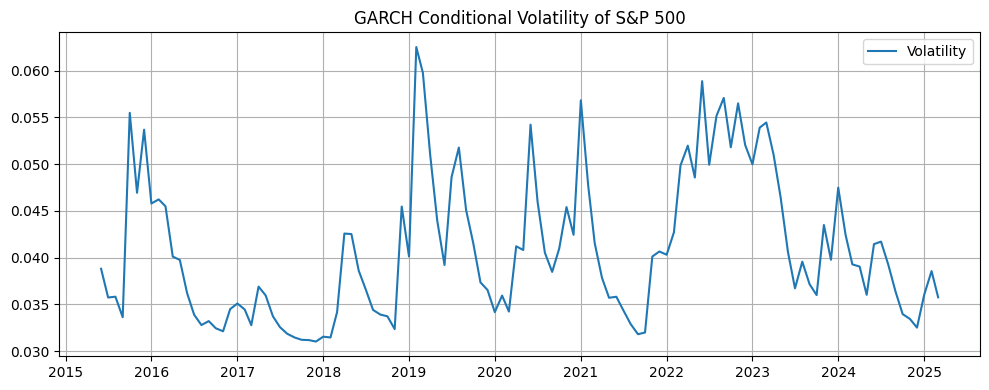

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(results.conditional_volatility, label='Volatility')
plt.title("GARCH Conditional Volatility of S&P 500")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The conditional volatility estimated by the GARCH model implies a high degree of volatility clustering and heteroskedasticity, bolstering the need for a GARCH model to accurately model the SP500 development

**4. Conclusion**

This report set out to examine whether changes in key macroeconomic variables; Nonfarm payrolls (PAYEMS) and the federal funds rate (FEDFUNDS) can help explain S&P 500 stock market returns and volatility. Using a combination of ARIMAX and GARCH models, the analysis provides evidence that PAYEMS plays a significant role in shaping financial market behavior, while FEDFUNDS does not, indicating that there are some fundamental issues in how the data is fed to the model, considering that the FEDFUNDS has a crucial impact on cost of capital and thus also equity valuations.

The ARIMAX(2, 0, 2) model demonstrates that month-over-month changes in PAYEMS are a strong and statistically significant predictor of stock returns, suggesting that stronger-than-expected employment growth tends to be associated with improved equity performance. Conversely, changes in the federal funds rate, while having a negative impact as expected, do not exhibit a statistically significant effect in this. The model also captures meaningful autocorrelation and shock dynamics in returns.

To capture time-varying market volatility, a GARCH(1,1) model was used. The results confirm the presence of volatility clustering. Volatility was found to be stationary but persistent, indicating that shocks have a lasting but diminishing influence over time. While PAYEMS was again significant in influencing expected returns within the GARCH framework, the FEDFUNDS variable remained insignificant as in the ARIMAX framework.

Interestingly, the statistical significance of PAYEMS and insignificance of FEDFUNDS was strengthened in the GARCH model compared to the ARIMAX model. This, paired with evidence of heteroskedasticity in the ARIMAX model and the plot of conditional volatility from the GARCH model may point us to believing that the GARCH model was necessary for accurately estimating the impact of these exogenous variables.

Together, these results suggest that labor market strength is a key macroeconomic signal priced into equity returns. Although the federal funds rate is widely known to impact the S&P 500 inversely, the model failed to catch the impact, indicating a fundamental issue in how the data is presented to the model. Moreover, the presence of conditional heteroskedasticity reinforces the importance of modeling volatility explicitly when analyzing financial time series. Further work could extend this analysis by incorporating forward-looking measures of market expectations to the funds rate or probably also a broader set of macroeconomic indicators.

**7. Feedback from peer review**

This report was peer reviewed by Group 23, who provided constructive feedback highlighting both strengths and areas for improvement. This section summarizes their comments and outlines a clear path for enhancing the quality and depth of the report.

*Strengths of report:*<br>
Group 23 outlined several positive aspects:<br>
- Well structured report
- Diverse range of models and statistical techniques employed

*Weaknesses of report:*<br>
*Interest rates and choice of explanatory variables*
- The federal funds rate is not typically the interest rate most directly linked to equity capital markets. Group 23 suggested considering alternative rates, such as an interbank offered rate or the Secured Overnight Financing Rate (SOFR), which may better capture market dynamics.- The federal funds rate both directly affects equity capital markets and responds to changes in both equity capital markets and the overall economy. As such, treating it as a one-way effect from the federal funds rate to equity capital markets will omit some important dynamics
-  They also noted that the federal funds rate is both an influencing and responding variable—it affects equity markets but also reacts to them and to broader economic conditions. As such, treating it solely as an exogenous driver of market outcomes may oversimplify the causal relationships.
- Additionally, the analysis may suffer from an omitted variable bias, as there are likely other important economic variables (e.g., inflation expectations, global financial indicators) that influence the S&P 500 and correlate with employment and interest rate metrics.

*Data sampling and transformation*<br>
- The nonfarm payroll data includes a significant outlier stemming from the COVID-19 pandemic, which could distort regression estimates or lead to spurious inferences.
- The S&P 500 time series was downsampled to a monthly frequency, which may obscure important intra-month dynamics and reduce the precision of estimating short-term effects from the explanatory variables.

**Path forward for enhancing report:**<br>

*Refining the Choice of Explanatory Variables*
To enhance the economic relevance and empirical accuracy of the analysis, a key improvement involves reconsidering the choice of interest rate used as an explanatory variable. The federal funds rate, while a central policy instrument, may not directly reflect the borrowing costs or short-term financing conditions that most immediately affect equity markets. A more market-driven alternative such as the Secured Overnight Financing Rate (SOFR) could provide a clearer link to investor behavior and equity valuations.

SOFR has emerged as a preferred benchmark in post-LIBOR markets, grounded in actual transactions in the overnight repo market. Unlike the federal funds rate, which is set by the Federal Reserve and influenced by policy expectations, SOFR reflects real-time market dynamics and liquidity. As such, incorporating SOFR may better capture changes in the cost of capital and market-based risk sentiment, thereby improving the explanatory power of the model with respect to stock market returns.

Furthermore, the inclusion of additional macroeconomic variables—such as inflation indicators, consumer confidence indices, or leading economic indicators—could help mitigate omitted variable bias. These additions would provide a more complete picture of the underlying forces influencing both employment and financial market outcomes.

*Improving Model Specification*
The current model assumes a unidirectional relationship from explanatory variables (interest rates and employment) to stock returns. However, this simplification may obscure the dynamic feedback loops present in real-world financial systems. For example, equity market conditions can influence monetary policy expectations, which in turn affect interest rates—highlighting the need for a model that accommodates endogeneity and mutual causation.

A natural extension is the use of a Vector Autoregression (VAR) model, which treats all variables in the system as potentially endogenous. VAR models allow for the modeling of lagged interdependencies between variables, enabling the analysis of how shocks to one variable (e.g., a surprise change in payroll statistics) propagate through the system and affect others over time. This is particularly valuable for capturing the dynamic interplay between labor market data, interest rate fluctuations, and stock market behavior.

In addition, a VAR framework facilitates tools such as impulse response functions and forecast error variance decompositions, which can provide more nuanced insights into the relative impact of each variable over different time horizons. This richer structure would enable a more sophisticated understanding of the causal relationships at play and support more informed conclusions.

I sincerely want to thank group 23 for a well thought through peer review and an interesting presentation on their empirical topic.

**6. Use of LLMs**

I have used LLMs throughout the report to explain me complex topics and debug my code, as I find that both can be very time-consuming activities, and as such I see that my work has become much more efficient by utilising LLMs such as ChatGPT.<br>
I find that using LLMs for university assignments can be a two-sided sword, as it can both empower the user to focus on the more important tasks at hand, and also give the user a way around actually learning and implementing the tasks.<br>
Therefore, I have tried to contain LLM usage to the tasks that provide me the lowest marginal benefit compared to the time I spend on them. <br>

**7. References**

- Bollerslev, T. (1986). *Generalized Autoregressive Conditional Heteroskedasticity*. Journal of Econometrics.
- Box, G. E. P., & Jenkins, G. M. (1970). *Time Series Analysis: Forecasting and Control*. Holden-Day.
- Engle, R. F. (1982). *Autoregressive Conditional Heteroskedasticity with Estimates of the Variance of UK Inflation*. Econometrica.
- Risstad, M. & Lavrutich, M. (2025). *TIØ4317 Lecture Slides*. The Norwegian University of Science and Technology.
